In [1]:
import os
import glob
from keras.preprocessing import image
import numpy as np
from PIL import Image, UnidentifiedImageError
import sys
from keras import backend
from keras.models import load_model
import pandas as pd

from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

import matplotlib.pyplot as plt

In [2]:
#Definicao do repertorio home do projet
os.chdir("C:\\Users\\Utilisateur\\Downloads\\tmp\\MBA\\")
#Parametros
sizeImg = 128

In [3]:
#Lista de tags das 15 classes trabalhadas 
lstTagClas = ['arvore', 'ave', 'cachorro', 'caminhao', 'carro', 'casa', 'cavalo', \
              'gato', 'mar', 'montanha', 'ponte', 'praia', 'predio', 'rio', 'sol']
#Caso nao seja ainda feito, se ordena a lista por ordem alfabetico
lstTagClas.sort()
print(type(lstTagClas))
#Criacao do dicionario tag-id label das classes
dicTagId = {lstTagClas[idx]:idx for idx in range(len(lstTagClas))}
#Criacao do dicionario id-tag label das classes
dicIdTag = {idx:lstTagClas[idx] for idx in range(len(lstTagClas))}

countClasses = len(lstTagClas)
print(countClasses)


<class 'list'>
15


In [4]:
#Funcoes gerais para montar a lista de label de uma imagem (problema multi-label), codificar esta lista de label (gera o target da imagem),
# decodificar a target (gera a lista de label da imagem)

# Funcao para ter os tags de uma imagem a parte do nome do seu arquivo e da lista das classes trabalhadas
def getTagImg(nameFile, lstTagClas):
    #Recuperacao dos tags das classes trabalhadas do nome do arquivo
    lstTagImg = [tag for tag in nameFile.split('-') if tag in lstTagClas]
    #print(lstTagImg)
    return lstTagImg

# Funcao de codificaca do jogo de saida
def oneHotEncode(lstTagImg, dicTagId):
    '''Retorna um array de binary com 1 (classe presente) ou 0 (classe nao presente) para cada classe trabalhada, 
    na posicao definida pelo ID da classe'''
    #Criacao do array de tamanho do dicionario de mapping tag-id, inicializado a 0
    npIdImg = np.zeros(len(dicTagId), dtype=int)
    #Loop sobre a lista dos diferentes tags da imagem
    for tag in lstTagImg:
        #Se posiciona 1 na posicao do arry que corresponde ao ID do tag
        npIdImg[dicTagId[tag]] = 1
    #Se retorna o array de codificacao do jogo de saida da imagem
    return npIdImg

# Funcao de decodificaca do jogo de saida (target) en lista dos tags da foto
def oneHotDecode(tgt, dicIdTag):
    '''Retorna uma lista dos tags de ID correspondendo as posicoes do jogo de saida com 1'''
    #Recupera as posicoes preenchidas
    posId = np.nonzero(tgt)
    #Monta a lista dos tags da imagem
    lstTag = [dicIdTag[id] for id in posId[0]]
    #OBS: Precisa recuperar o indice 0 de posId prque np.nonzero retorna tuple de array de posicao nao 0, um elemento por dimensao do array
    return lstTag
    

In [14]:
#Funcao de carregamento e serializacao do jogo de entrada X (pixels das imagens) e de saida (one-hot encoding dos labels das imagens)
def loadImg(maskNameFile="*", sizeImg=128, nomeRepertory="C:\\Users\\Utilisateur\\Downloads\\tmp\\MBA\\"):
    os.chdir(nomeRepertory)
    # Criacao das listas com as imagens e com os labels
    lstImgs = []
    lstTgts = []
    lstNameFiles = []
    gntImages = glob.iglob(f"{maskNameFile}", recursive=False)
    #OBS: Pensar a regegar o generator que ficou vazio depois do loop que gerou o dico dos tags por imagem
    for pth in gntImages:
        try:
            #Se tratar-se bem de um arquivo
            if os.path.isfile(pth):
                nameFile = os.path.basename(pth)
                #print(nameFile)
                # Visualizacao da imagem sem transformacao
                #img = load_img(fr'{pth}')
                #plt.imshow(img)
                #plt.show()
                #plt.pause(1) 
                # Dados dos pixels desta imagem de tamanho limitado para economizar memoria
                img = image.load_img(fr'{pth}', target_size=(sizeImg,sizeImg))
                # convert to numpy array
                img = image.img_to_array(img)
                #OBS: No exemplo deep_learning_for_computer_vision.pdf, pagina 334, esta indicado de usar dtype uint8, mas como 
                #     o predict sobre os modelos pretreinados sem ajuste, nao foi bem succedido, se deixou os valores originais.
                # Target desta imagem
                lstTagImg = getTagImg(nameFile, lstTagClas)
                tgt = oneHotEncode(lstTagImg, dicTagId)
                #print(tgt)
                #Se uma das classes do projeto foi reconhecida a traves o nome do arquivo
                if (np.nonzero(tgt)[0].size > 0):
                    # Adicao da imagem, da target e do nome arquivo as listas
                    lstImgs.append(img)
                    lstTgts.append(tgt)
                    lstNameFiles.append(nameFile)
        except UnidentifiedImageError:
            print(f'Warning: O arquivo {nameFile} nao pode estar carregado porque nao esta reconhecido como imagem.')
        except OSError:
            print(f'Warning: O arquivo {nameFile} nao pode estar carregado porque gera um erro OS a pesar estar reconhecido como imagem.')
        except:
            print(nameFile)
            print("Unexpected error:", sys.exc_info()[0])
            raise
            
    #Se passa as imagens, as targets e nomes arquivo em array numpy
    X = np.asarray(lstImgs)
    Y = np.asarray(lstTgts, dtype=np.int8)
    npNameFiles = np.asarray(lstNameFiles)

    #Se salva estes arrays em um arquivo compressado de padrao numpy
    np.savez_compressed('XY_TestTransferLearning2.npz', X, Y, npNameFiles)  
    

In [22]:
#Se cria o arquivo de compressao com a mascara de imagem e o tamanho de imagens desejados
#OBS: A descomentar so na primeira execucao, ja que depois se pode ler diretamente do arquivo criado na primeira execucao
loadImg("*", sizeImg)
#Se recarrega o jogo de entrada e saida a parte do arquivo de compressao numpy
data = np.load('XY_TestTransferLearning2.npz')
X, Y, npNameFiles = data['arr_0'], data['arr_1'], data['arr_2']
print(f'Loaded: X: {X.shape}, Y: {Y.shape}, npNameFiles: {npNameFiles.shape}\n')

#Se conta as imagens por classe estudada
print("Total imagens por classe estudada:")
print(pd.Series(data=Y.sum(axis=0), index=lstTagClas))
#Se aproveita do jogo de saida formada de uma serie de 15 booleans com 0 se nao a classe e 1 se tem a classe, para chegar
# ao total por classe, somando no axe dos rows (somando no axe de coluna, indicaria o total de tag por imagem).

#Stats do numero de classe por imagem
print("\nStats do total de classe estudada por imagem:")
print(pd.DataFrame(data=Y.sum(axis=1), columns=['Num. Classes']).describe())


Loaded: X: (750, 128, 128, 3), Y: (750, 15), npNameFiles: (750,)

Total imagens por classe estudada:
arvore      301
ave          83
cachorro    104
caminhao     80
carro       179
casa        112
cavalo       91
gato         62
mar         173
montanha    111
ponte        94
praia       100
predio       87
rio         112
sol         114
dtype: int32

Stats do total de classe estudada por imagem:
       Num. Classes
count    750.000000
mean       2.404000
std        0.723982
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        5.000000


In [16]:
# Funcao de calculo da metrica Fbeta para uma classificacao multi-classe/label
#Se cria a metrica fbeta para avaliar o treinamento do modelo (se vai usar a principio com o beta 1 para ter usar a metrica F1)
#OBS: A funcao nativa foi retirada do keras devido a gerar confusao em funcao do calculo estar realizado ao nivel batch ou por metrica
#     A avaliar se a funcao copiada de deep_learning_for_computer_vision.pdf (pagina 335) esta adequada ou se precisa de uma funcao
#     mais sofisticada como explicada no pdf F-beta Score in Keras Part III. Creating custom F-beta score for… _ by Jolomi Tosanwumi _ Towards Data Science
def fBetaKeyras(YTrue, YPred, beta=1):
    # clip as predicoes entre 0 e 1 (inferior a 0 passa 0 e superior a 1 passa 1)
    YPred = backend.clip(YPred, 0, 1)
    # calcula os elementos que fazem parte do calculo do indicador FBeta
    tp = backend.sum(backend.round(backend.clip(YTrue * YPred, 0, 1)), axis=1)  #Verdadeiros Positivos
    fp = backend.sum(backend.round(backend.clip(YPred - YTrue, 0, 1)), axis=1)  #Falsos Positivos
    fn = backend.sum(backend.round(backend.clip(YTrue - YPred, 0, 1)), axis=1)  #Falsos Negativos
    # Calculo da acuracidade (precisao)
    p = tp / (tp + fp + backend.epsilon())
    # Calculo do recall
    r = tp / (tp + fn + backend.epsilon())
    # Calculo do FBeta, com a media de cada classe
    bb = beta ** 2
    fBetaScore = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
    #OBS: Uso de uma constante infinitessima epsilon baixa para nao cair no erro de divisao por zero
        
    return fBetaScore


In [17]:
# Se deserializa o modelo
#Modelo com jogo de treinamento limitado a 70%, que apresentou a melhor metrica para o jogo de teste
#model = load_model('modelVGG16DataAugmFineTuning2.h5', custom_objects={'fBetaKeyras':fBetaKeyras})

#Modelo com jogo de treinamento completo, que treinou com as mesmas tecnicas que o modelo anterior usando callback para 
# conservar os pesos da melhor epoca e para ter uma fim antecipada depois de 30 epocas sem melhora da metrica
model = load_model('modelVGG16DataAugmFineTuning2Full.h5', custom_objects={'fBetaKeyras':fBetaKeyras})

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [19]:
#Predicao com este modelo de todo o jogo de foto com uma classe presente na lista das 15 classes do treinamento do modelo
#Objeto para centralizar as fotos como esperado pelo modelo de origem VGG16 usado para montar o nosso modelo especefico via
# transfer learning
#dataGen = ImageDataGenerator(featurewise_center=True)
#dataGen.mean = [123.68, 116.779, 103.939]
#iterator = dataGen.flow(X, Y, batch_size=1) #Se usa todo o jogo de treinamento e de teste
#Outra solucao para centralizar, evitando de passar pelo gerador, que nao parece retornar o data frame de predicao com a mesma
# ordem que o jogo de entrada X
# Se centraliza manualmente os dados dos 3 camais de cor dos pixels
XPrep = X - [123.68, 116.779, 103.939]

# Compilacao do modelo para poder usar evaluate
#opt = SGD(learning_rate=0.01, momentum=0.9)
#from keras.optimizers import SGD
#model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fBetaKeyras])
model.compile(loss='binary_crossentropy', metrics=[fBetaKeyras])
score = model.evaluate(XPrep, Y)

#YPred = model.predict_generator(iterator) is deprecated and will be removed in a future version.
YPred = model.predict(XPrep)


1/1 [==============================] - 0s 2ms/step - loss: 0.0473 - fBetaKeyras: 0.9000


In [20]:
YPred.shape

(2, 15)

Score F1: test=0.8571

============ Index 0: caminhao-sol-arvore-1.jpg ================


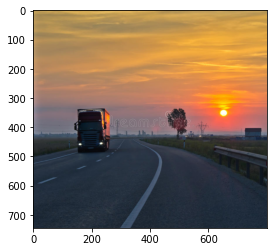

Tags da imagem: ['arvore', 'caminhao', 'sol']
Tags preditos: [('caminhao', '99.48%'), ('sol', '92.51%')]

============ Index 1: caminhao-sol-arvore-2.jpg ================


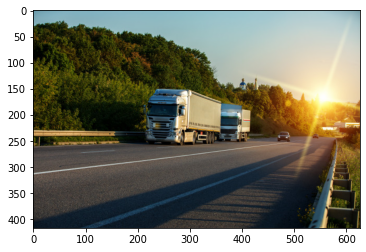

Tags da imagem: ['arvore', 'caminhao', 'sol']
Tags preditos: [('arvore', '67.41%'), ('caminhao', '100.0%'), ('sol', '99.4%')]


In [21]:
#Metrica F1 com a funcao especefica passada na compilacao no modelo
score = fBetaKeyras(backend.variable(Y), backend.variable(YPred.round()), 2)
print('Score F1: test=%.4f' % (score))
#Loop sobre todas as fotos do jogo de treinamento para compararar as predicoes contra os tags reais
for idx in range(len(Y)): #range(160, 180)
    nameFile = npNameFiles[idx] 
    print(f'\n============ Index {idx}: {nameFile} ================')
    #Visualizacao da imagem sem transformacao
    img = load_img(fr'{nameFile}')
    plt.imshow(img)
    plt.show()
    #Consulta do decode da target (volta para uma lista de tags)
    lstTag = oneHotDecode(Y[idx], dicIdTag)
    print(f'Tags da imagem: {lstTag}')
    #Consulta dos tags das classes preditas com uma probabilidade superior a 50%
    lstClasPred = [(dicIdTag[i], str(round(YPred[idx][i]*100, 2))+'%') for i in range(len(YPred[idx])) if YPred[idx][i] > 0.5]
    print(f'Tags preditos: {lstClasPred}')


In [ ]:
#A testar depois com um jogo novo recuperado de internet, que nao serviu nem de treinamento nem de teste

In [70]:
#Carga das novas fotos

#Parametros
sizeImg = 128
repertNovasFotos = "C:\\Users\\Utilisateur\\Downloads\\tmp\\"

loadImg("*novo*", sizeImg, repertNovasFotos)

#Se recarrega o jogo de entrada e saida a parte do arquivo de compressao numpy
data = np.load('XY_TestTransferLearning2.npz')
X, Y, npNameFiles = data['arr_0'], data['arr_1'], data['arr_2']
print(f'Loaded: X: {X.shape}, Y: {Y.shape}, npNameFiles: {npNameFiles.shape}\n')

#Se conta as imagens por classe estudada
print("Total imagens por classe estudada:")
print(pd.Series(data=Y.sum(axis=0), index=lstTagClas))
#Se aproveita do jogo de saida formada de uma serie de 15 booleans com 0 se nao a classe e 1 se tem a classe, para chegar
# ao total por classe, somando no axe dos rows (somando no axe de coluna, indicaria o total de tag por imagem).

#Stats do numero de classe por imagem
print("\nStats do total de classe estudada por imagem:")
print(pd.DataFrame(data=Y.sum(axis=1), columns=['Num. Classes']).describe())


Loaded: X: (60, 128, 128, 3), Y: (60, 15), npNameFiles: (60,)

Total imagens por classe estudada:
arvore      34
ave          8
cachorro     8
caminhao    10
carro       11
casa         8
cavalo       7
gato         7
mar          9
montanha     6
ponte        8
praia        7
predio       8
rio          9
sol          9
dtype: int32

Stats do total de classe estudada por imagem:
       Num. Classes
count     60.000000
mean       2.483333
std        0.812856
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        4.000000


In [71]:
#Predicao
# Se centraliza manualmente os dados dos 3 camais de cor dos pixels
XPrep = X - [123.68, 116.779, 103.939]

YPred = model.predict(XPrep)

Score F1: test=0.6382

============ Index 0: arvore-ave-novo1.jpg ================


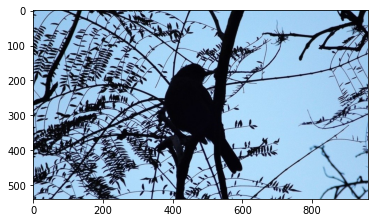

Tags da imagem: ['arvore', 'ave']
Tags preditos: [('arvore', '99.7%'), ('ave', '100.0%')]

============ Index 1: arvore-ave-novo2.jpg ================


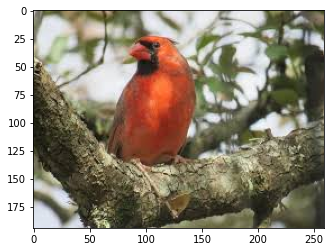

Tags da imagem: ['arvore', 'ave']
Tags preditos: [('ave', '99.96%')]

============ Index 2: arvore-ave-novo3.jpg ================


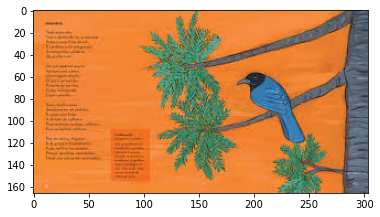

Tags da imagem: ['arvore', 'ave']
Tags preditos: [('arvore', '77.05%'), ('ave', '96.2%')]

============ Index 3: arvore-cachorro-novo1.jpg ================


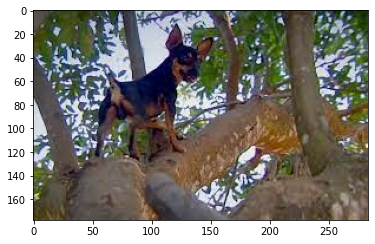

Tags da imagem: ['arvore', 'cachorro']
Tags preditos: [('arvore', '99.04%'), ('cachorro', '89.52%'), ('cavalo', '57.22%')]

============ Index 4: arvore-cachorro-novo2.jpg ================


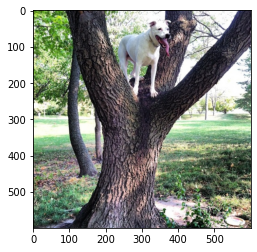

Tags da imagem: ['arvore', 'cachorro']
Tags preditos: [('arvore', '97.91%'), ('gato', '97.57%')]

============ Index 5: arvore-cachorro-novo3.jpg ================


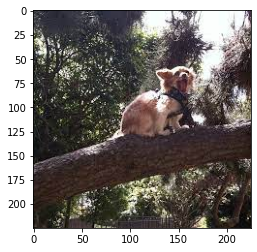

Tags da imagem: ['arvore', 'cachorro']
Tags preditos: [('arvore', '78.34%'), ('ave', '84.6%'), ('cavalo', '57.3%')]

============ Index 6: arvore-caminhao-novo1.jpg ================


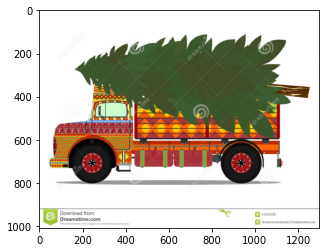

Tags da imagem: ['arvore', 'caminhao']
Tags preditos: [('caminhao', '99.98%'), ('gato', '99.94%')]

============ Index 7: arvore-caminhao-novo2.jpg ================


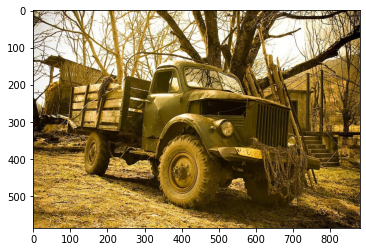

Tags da imagem: ['arvore', 'caminhao']
Tags preditos: [('arvore', '100.0%')]

============ Index 8: arvore-caminhao-novo3.jpg ================


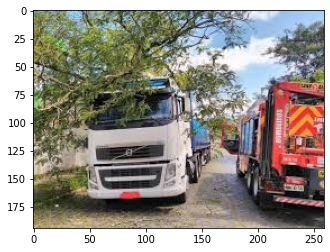

Tags da imagem: ['arvore', 'caminhao']
Tags preditos: [('arvore', '96.27%'), ('carro', '90.34%'), ('casa', '56.07%')]

============ Index 9: arvore-carro-casa-novo1.jpg ================


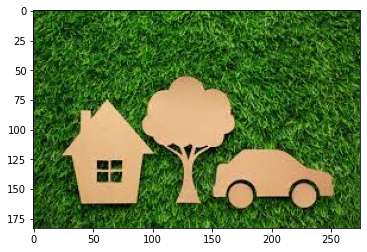

Tags da imagem: ['arvore', 'carro', 'casa']
Tags preditos: [('arvore', '92.19%'), ('ave', '57.38%')]

============ Index 10: arvore-carro-novo1.jpg ================


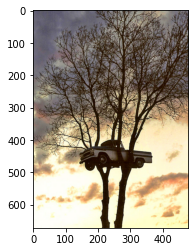

Tags da imagem: ['arvore', 'carro']
Tags preditos: [('arvore', '96.68%'), ('ave', '92.03%')]

============ Index 11: arvore-carro-novo2.jpg ================


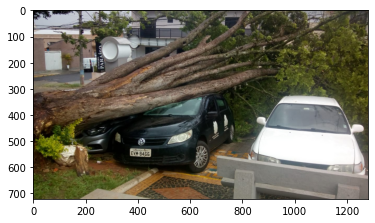

Tags da imagem: ['arvore', 'carro']
Tags preditos: [('arvore', '95.2%'), ('caminhao', '60.86%')]

============ Index 12: arvore-carro-novo3.jpg ================


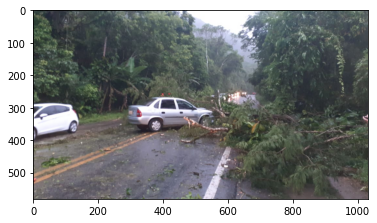

Tags da imagem: ['arvore', 'carro']
Tags preditos: [('arvore', '99.3%')]

============ Index 13: arvore-casa-novo1.jpeg ================


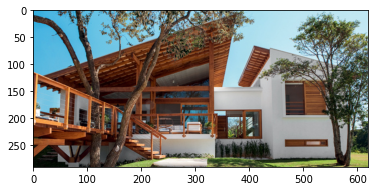

Tags da imagem: ['arvore', 'casa']
Tags preditos: [('arvore', '89.24%'), ('caminhao', '69.9%'), ('casa', '73.68%')]

============ Index 14: arvore-casa-novo3.jpg ================


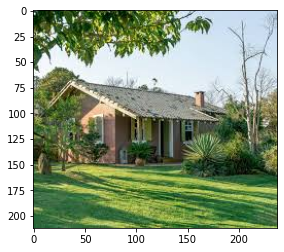

Tags da imagem: ['arvore', 'casa']
Tags preditos: [('arvore', '99.74%'), ('casa', '93.86%')]

============ Index 15: arvore-cavalo-novo1.jpg ================


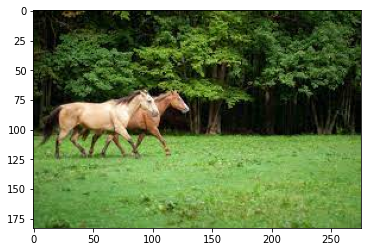

Tags da imagem: ['arvore', 'cavalo']
Tags preditos: [('arvore', '99.89%'), ('cavalo', '99.26%')]

============ Index 16: arvore-cavalo-novo2.jpg ================


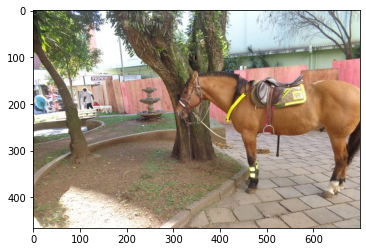

Tags da imagem: ['arvore', 'cavalo']
Tags preditos: [('arvore', '99.96%'), ('cavalo', '98.57%')]

============ Index 17: ave-gato-novo1.jpg ================


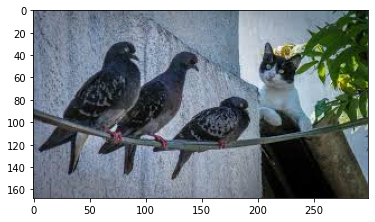

Tags da imagem: ['ave', 'gato']
Tags preditos: [('arvore', '79.34%'), ('ave', '82.07%')]

============ Index 18: ave-gato-novo2.jpg ================


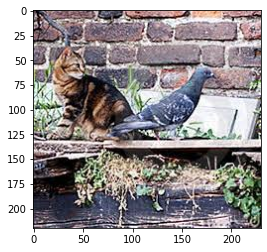

Tags da imagem: ['ave', 'gato']
Tags preditos: [('ave', '99.99%')]

============ Index 19: ave-novo1.jpg ================


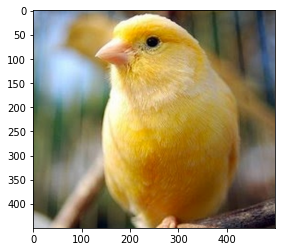

Tags da imagem: ['ave']
Tags preditos: [('ave', '100.0%')]

============ Index 20: ave-novo2.jpg ================


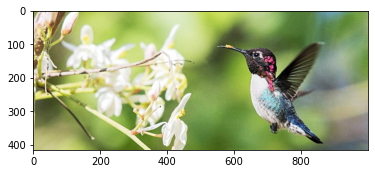

Tags da imagem: ['ave']
Tags preditos: [('ave', '100.0%')]

============ Index 21: ave-novo3.jpg ================


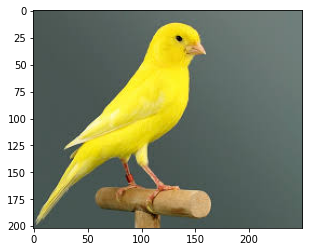

Tags da imagem: ['ave']
Tags preditos: [('ave', '99.91%')]

============ Index 22: cachorro-arvore-praia-montanha-novo1.jpg ================


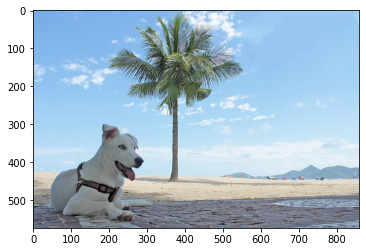

Tags da imagem: ['arvore', 'cachorro', 'montanha', 'praia']
Tags preditos: [('arvore', '95.87%'), ('mar', '93.29%'), ('praia', '88.99%')]

============ Index 23: cachorro-praia-mar-novo1.jpg ================


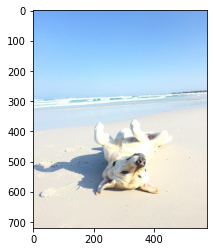

Tags da imagem: ['cachorro', 'mar', 'praia']
Tags preditos: [('mar', '91.52%'), ('praia', '86.42%')]

============ Index 24: caminhao-arvore-sol-novo1.jpeg ================


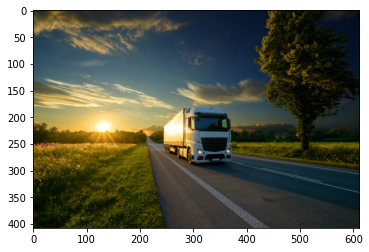

Tags da imagem: ['arvore', 'caminhao', 'sol']
Tags preditos: [('arvore', '84.69%'), ('caminhao', '99.8%'), ('sol', '91.78%')]

============ Index 25: caminhao-carro-novo1.jpeg ================


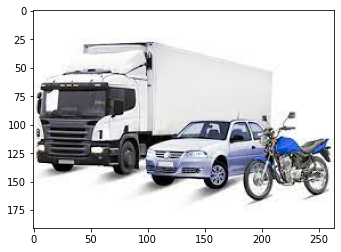

Tags da imagem: ['caminhao', 'carro']
Tags preditos: [('carro', '98.52%')]

============ Index 26: caminhao-carro-novo2.jpeg ================


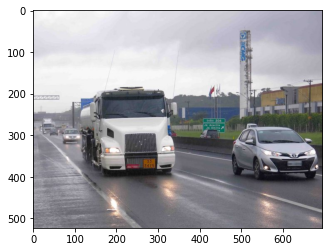

Tags da imagem: ['caminhao', 'carro']
Tags preditos: [('caminhao', '97.07%'), ('carro', '51.97%')]

============ Index 27: caminhao-carro-novo3.jpeg ================


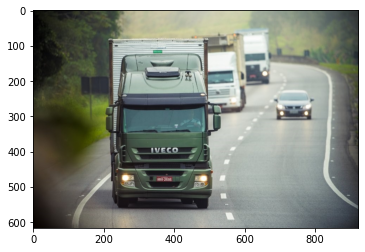

Tags da imagem: ['caminhao', 'carro']
Tags preditos: [('caminhao', '100.0%'), ('carro', '99.96%')]

============ Index 28: caminhao-cavalo-novo1.jpeg ================


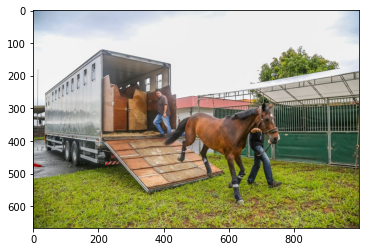

Tags da imagem: ['caminhao', 'cavalo']
Tags preditos: [('arvore', '89.04%'), ('casa', '72.27%'), ('cavalo', '99.65%')]

============ Index 29: casa-arvore-carro-novo1.jpeg ================


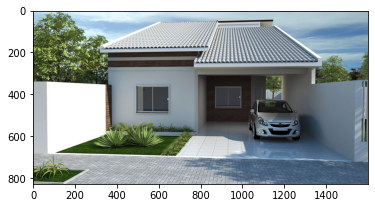

Tags da imagem: ['arvore', 'carro', 'casa']
Tags preditos: [('carro', '56.32%'), ('casa', '85.93%')]

============ Index 30: casa-arvore-novo1.jpeg ================


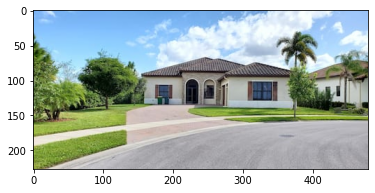

Tags da imagem: ['arvore', 'casa']
Tags preditos: [('arvore', '99.89%'), ('casa', '98.75%')]

============ Index 31: casa-carro-arvore-novo1.jpg ================


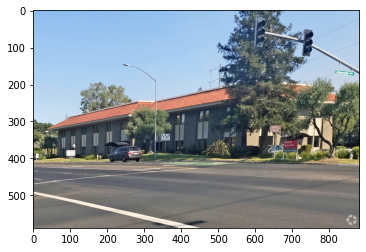

Tags da imagem: ['arvore', 'carro', 'casa']
Tags preditos: [('arvore', '90.7%'), ('caminhao', '67.95%')]

============ Index 32: casa-carro-novo1.jpg ================


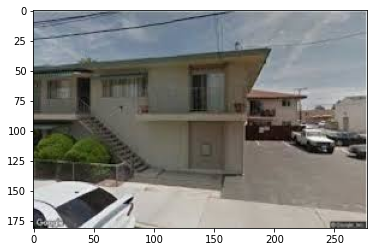

Tags da imagem: ['carro', 'casa']
Tags preditos: [('carro', '87.22%'), ('casa', '76.28%')]

============ Index 33: cavalo-caminhao-arvore-novo1.jpg ================


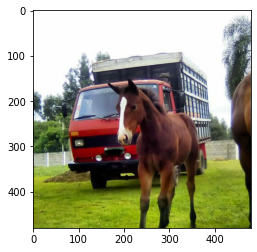

Tags da imagem: ['arvore', 'caminhao', 'cavalo']
Tags preditos: [('arvore', '61.42%'), ('cavalo', '99.97%')]

============ Index 34: gato-cachorro-novo1.jpg ================


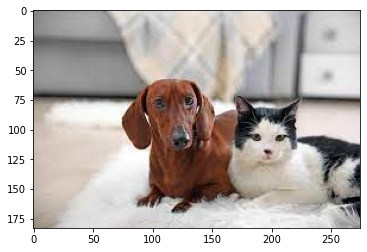

Tags da imagem: ['cachorro', 'gato']
Tags preditos: [('cachorro', '99.66%')]

============ Index 35: gato-cachorro-novo2.jpg ================


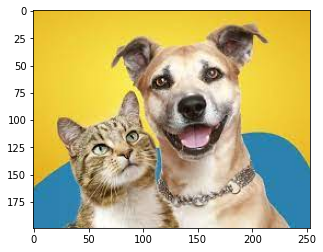

Tags da imagem: ['cachorro', 'gato']
Tags preditos: [('cachorro', '95.35%'), ('gato', '100.0%')]

============ Index 36: gato-sol-mar-novo1.jpg ================


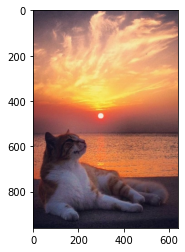

Tags da imagem: ['gato', 'mar', 'sol']
Tags preditos: [('mar', '50.1%'), ('sol', '100.0%')]

============ Index 37: gato-sol-novo1.jpg ================


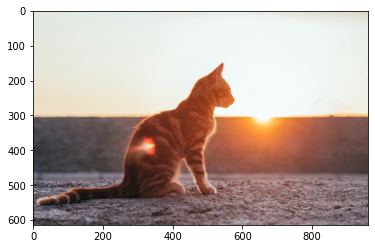

Tags da imagem: ['gato', 'sol']
Tags preditos: [('mar', '72.02%')]

============ Index 38: mar-praia-casa-arvore-novo1.jpg.crdownload ================


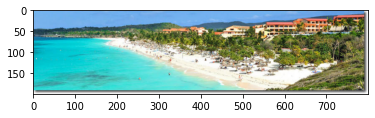

Tags da imagem: ['arvore', 'casa', 'mar', 'praia']
Tags preditos: [('arvore', '92.32%'), ('montanha', '98.92%'), ('ponte', '53.53%'), ('rio', '57.94%')]

============ Index 39: montanha-cavalo-novo1.jpg ================


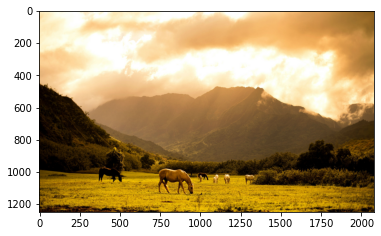

Tags da imagem: ['cavalo', 'montanha']
Tags preditos: [('montanha', '99.84%')]

============ Index 40: montanha-rio-arvore-novo1.jpg ================


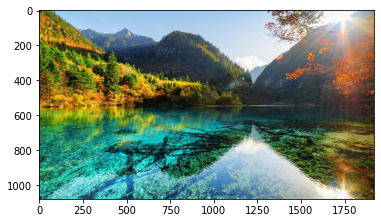

Tags da imagem: ['arvore', 'montanha', 'rio']
Tags preditos: [('arvore', '99.97%'), ('rio', '94.44%')]

============ Index 41: montanha-rio-arvore-novo2.jpg ================


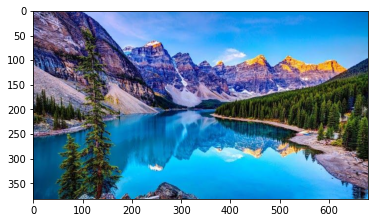

Tags da imagem: ['arvore', 'montanha', 'rio']
Tags preditos: [('arvore', '82.37%'), ('montanha', '91.22%'), ('rio', '99.98%')]

============ Index 42: ponte-caminhao-carro-novo1.jpg ================


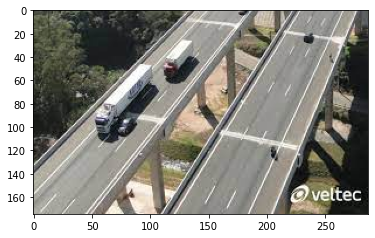

Tags da imagem: ['caminhao', 'carro', 'ponte']
Tags preditos: [('carro', '85.07%')]

============ Index 43: ponte-mar-arvore-predio-novo1.jpg ================


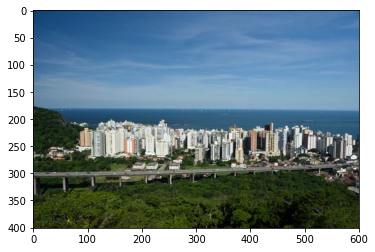

Tags da imagem: ['arvore', 'mar', 'ponte', 'predio']
Tags preditos: [('mar', '80.79%')]

============ Index 44: ponte-mar-arvore-predio-novo2.jpg ================


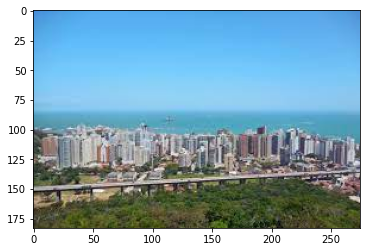

Tags da imagem: ['arvore', 'mar', 'ponte', 'predio']
Tags preditos: [('mar', '58.98%'), ('ponte', '56.49%')]

============ Index 45: ponte-mar-predio-praia-novo1.jpg ================


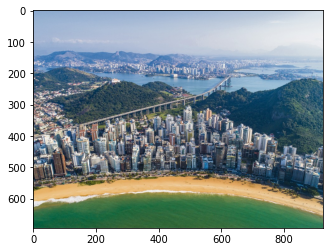

Tags da imagem: ['mar', 'ponte', 'praia', 'predio']
Tags preditos: [('montanha', '92.61%'), ('ponte', '78.67%')]

============ Index 46: ponte-predio-arvore-novo1.jpg ================


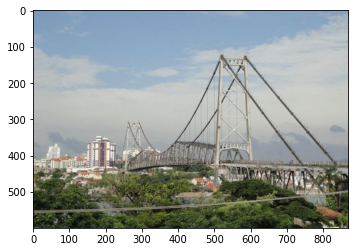

Tags da imagem: ['arvore', 'ponte', 'predio']
Tags preditos: [('ponte', '99.71%'), ('rio', '77.51%')]

============ Index 47: praia-cachorro-montanha-predio-novo1.jpg ================


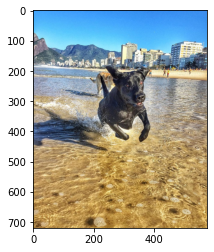

Tags da imagem: ['cachorro', 'montanha', 'praia', 'predio']
Tags preditos: [('cachorro', '85.3%'), ('mar', '86.42%')]

============ Index 48: predio-praia-mar-novo1.jpg.crdownload ================


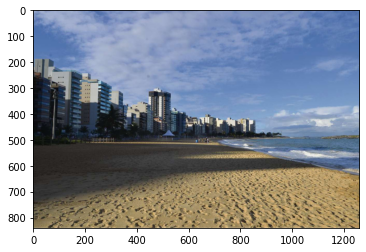

Tags da imagem: ['mar', 'praia', 'predio']
Tags preditos: [('mar', '71.36%'), ('predio', '51.49%')]

============ Index 49: rio-arvore-novo1.jpg ================


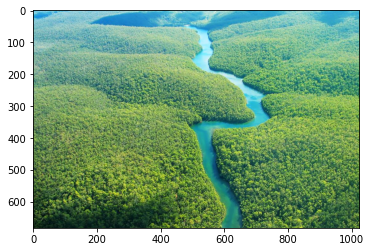

Tags da imagem: ['arvore', 'rio']
Tags preditos: [('arvore', '54.03%'), ('cachorro', '78.94%')]

============ Index 50: rio-novo1.jpg ================


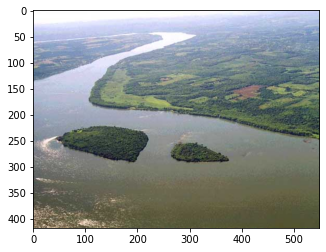

Tags da imagem: ['rio']
Tags preditos: [('mar', '77.06%')]

============ Index 51: rio-ponte-novo1.jpg ================


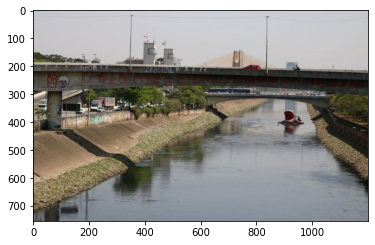

Tags da imagem: ['ponte', 'rio']
Tags preditos: [('ponte', '99.96%'), ('rio', '97.53%')]

============ Index 52: rio-ponte-predio-arvore-novo1.jpg ================


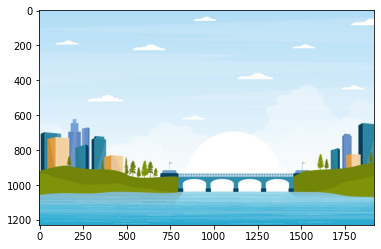

Tags da imagem: ['arvore', 'ponte', 'predio', 'rio']
Tags preditos: [('arvore', '80.31%'), ('mar', '91.06%'), ('praia', '89.98%')]

============ Index 53: rio-ponte-predio-novo1.jpg ================


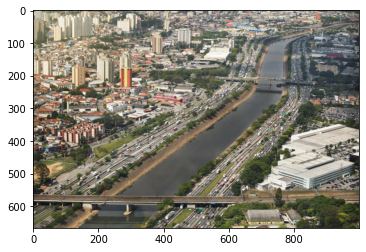

Tags da imagem: ['ponte', 'predio', 'rio']
Tags preditos: [('ponte', '80.31%'), ('rio', '63.95%')]

============ Index 54: rio-sol-arvore-novo1.jpg ================


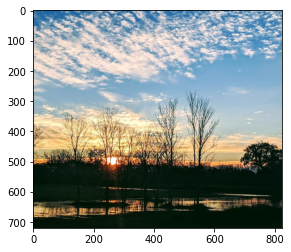

Tags da imagem: ['arvore', 'rio', 'sol']
Tags preditos: [('arvore', '99.76%'), ('montanha', '69.72%')]

============ Index 55: sol-arvore-gato-novo1.jpg ================


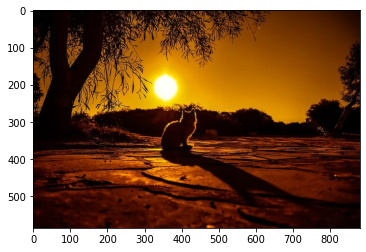

Tags da imagem: ['arvore', 'gato', 'sol']
Tags preditos: [('arvore', '90.69%'), ('rio', '52.23%'), ('sol', '99.97%')]

============ Index 56: sol-cavalo-mar-novo1.jpg ================


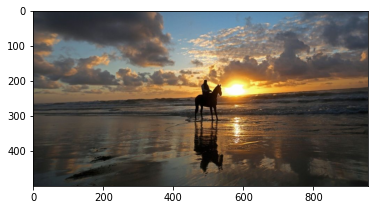

Tags da imagem: ['cavalo', 'mar', 'sol']
Tags preditos: [('mar', '51.11%'), ('ponte', '66.5%'), ('rio', '57.25%'), ('sol', '98.48%')]

============ Index 57: sol-cavalo-novo1.jpg ================


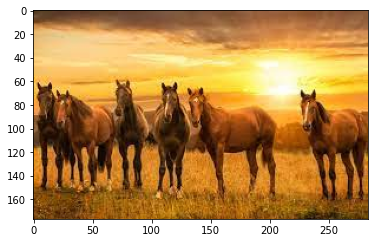

Tags da imagem: ['cavalo', 'sol']
Tags preditos: [('ave', '50.44%'), ('mar', '86.05%'), ('sol', '92.99%')]

============ Index 58: sol-montanha-mar-praia-novo1.jpg ================


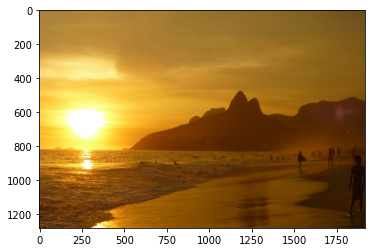

Tags da imagem: ['mar', 'montanha', 'praia', 'sol']
Tags preditos: [('arvore', '67.21%'), ('sol', '100.0%')]

============ Index 59: sol-rio-arvore-novo1.jpg ================


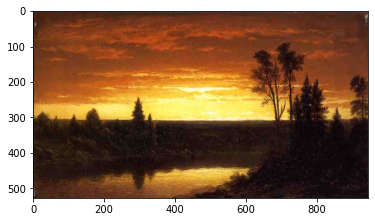

Tags da imagem: ['arvore', 'rio', 'sol']
Tags preditos: [('arvore', '77.02%'), ('predio', '55.69%'), ('rio', '58.27%'), ('sol', '98.7%')]


In [72]:
#Metrica F1 com a funcao especefica passada na compilacao no modelo
score = fBetaKeyras(backend.variable(Y), backend.variable(YPred.round()), 2)
print('Score F1: test=%.4f' % (score))
#Loop sobre todas as fotos do jogo de treinamento para compararar as predicoes contra os tags reais
for idx in range(len(Y)):
    nameFile = npNameFiles[idx] 
    print(f'\n============ Index {idx}: {nameFile} ================')
    #Visualizacao da imagem sem transformacao
    img = load_img(fr'{nameFile}')
    plt.imshow(img)
    plt.show()
    #Consulta do decode da target (volta para uma lista de tags)
    lstTag = oneHotDecode(Y[idx], dicIdTag)
    print(f'Tags da imagem: {lstTag}')
    #Consulta dos tags das classes preditas com uma probabilidade superior a 50%
    lstClasPred = [(dicIdTag[i], str(round(YPred[idx][i]*100, 2))+'%') for i in range(len(YPred[idx])) if YPred[idx][i] > 0.5]
    print(f'Tags preditos: {lstClasPred}')
